In [5]:
!pip install torchinfo

### Import Libraries

In [6]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

### Configuration

In [ ]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [ ]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [ ]:
data_dir = "/kaggle/input/brain-tumor-mri-images-44c"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Meningioma T1C+, Count: 369
Class: Meningioma T1, Count: 272
Class: _NORMAL T2, Count: 271
Class: _NORMAL T1, Count: 251
Class: Meningioma T2, Count: 233
Class: Astrocitoma T1C+, Count: 233
Class: Neurocitoma T1C+, Count: 223
Class: Schwannoma T1C+, Count: 194
Class: Astrocitoma T1, Count: 176
Class: Astrocitoma T2, Count: 171
Class: Schwannoma T1, Count: 148
Class: Neurocitoma T1, Count: 130
Class: Schwannoma T2, Count: 123
Class: Carcinoma T1C+, Count: 112
Class: Papiloma T1C+, Count: 108
Class: Neurocitoma T2, Count: 104
Class: Glioblastoma T1C+, Count: 94
Class: Oligodendroglioma T1, Count: 86
Class: Tuberculoma T1C+, Count: 84
Class: Carcinoma T2, Count: 73
Class: Oligodendroglioma T1C+, Count: 72
Class: Meduloblastoma T1C+, Count: 67
Class: Oligodendroglioma T2, Count: 66
Class: Carcinoma T1, Count: 66
Class: Papiloma T1, Count: 66
Class: Papiloma T2, Count: 63
Class: Ependimoma T2, Count: 57
Class: Glioblastoma T1, Count: 55
Class: Glioblastoma T2, Count: 55
Class: Ependi

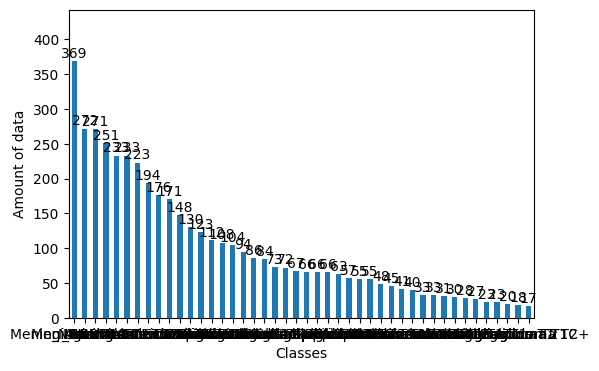

In [ ]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()